In [1]:
import nbimporter
from data_loader import load_data
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

c:\Users\Nouran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (224, 224)  # ResNet50 default input size
BATCH_SIZE = 64
EPOCHS = 50

In [5]:
# Load data (using your existing function)
train_gen, val_gen, test_gen,_= load_data(
    train_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train",
    valid_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/valid",
    test_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)


Found 4793 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [6]:
# Number of classes (from your loaded generators)
NUM_CLASSES = len(train_gen.class_indices)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 30


In [7]:
# Load pre-trained VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

In [8]:
base_model.trainable = False  # Freeze all layers

In [9]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Better than Flatten for generalization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [10]:
# Build final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,780,190 (60.20 MB)

 Trainable params: 1,065,502 (4.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
 #Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
]

In [12]:
# Phase 1: Train only the top layers
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 755s 10s/step - accuracy: 0.0433 - loss: 3.4606 - val_accuracy: 0.1953 - val_loss: 3.1948 - learning_rate: 1.0000e-04
Epoch 2/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 13:03 11s/step - accuracy: 0.1406 - loss: 3.3057

C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 502ms/step - accuracy: 0.1406 - loss: 3.3057 - val_accuracy: 0.1953 - val_loss: 3.1909 - learning_rate: 1.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 881s 12s/step - accuracy: 0.1178 - loss: 3.2202 - val_accuracy: 0.3906 - val_loss: 2.8471 - learning_rate: 1.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 314ms/step - accuracy: 0.1406 - loss: 3.1489 - val_accuracy: 0.3828 - val_loss: 2.8423 - learning_rate: 1.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 903s 12s/step - accuracy: 0.1925 - loss: 2.9883 - val_accuracy: 0.5000 - val_loss: 2.3265 - learning_rate: 1.0000e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 321ms/step - accuracy: 0.2812 - loss: 2.6728 - val_accuracy: 0.5000 - val_loss: 2.3223 - learning_rate: 1.0000e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 877s 12s/step - accuracy: 0.3134 - loss: 2.6031 - val_accuracy: 0.6484 - val_loss: 1.8285 - learning_rate: 1.0000e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 338ms/step - accuracy: 0.5000 

In [13]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8939 - loss: 0.3651

Test Accuracy: 89.33%


In [15]:
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

In [16]:
# Recompile the model for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 331s 4s/step - accuracy: 0.7639 - loss: 0.8181 - val_accuracy: 0.9219 - val_loss: 0.3112 - learning_rate: 1.0000e-05
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.7812 - loss: 0.7385 - val_accuracy: 0.9219 - val_loss: 0.3114 - learning_rate: 1.0000e-05
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.7644 - loss: 0.8325 - val_accuracy: 0.9219 - val_loss: 0.3109 - learning_rate: 1.0000e-05
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.8438 - loss: 0.6047 - val_accuracy: 0.9219 - val_loss: 0.3107 - learning_rate: 1.0000e-05
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.7652 - loss: 0.8180 - val_accuracy: 0.9219 - val_loss: 0.3069 - learning_rate: 1.0000e-05
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7656 - loss: 0.7777 - val_accuracy: 0.9219 - val_loss: 0.3066 - learning_rate: 1.0000e-05
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.

In [18]:
# === Step 5: Final evaluation ===
loss_fine, accuracy_fine = model.evaluate(test_gen)
print(f" Final Test Accuracy after fine-tuning: {accuracy_fine * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8939 - loss: 0.3590
 Final Test Accuracy after fine-tuning: 89.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


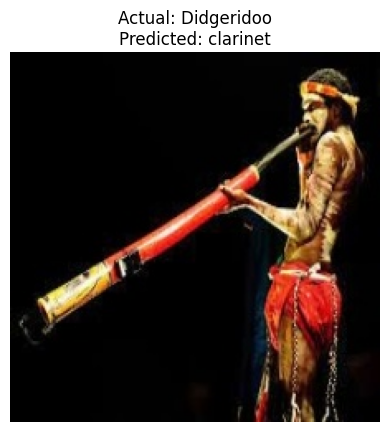

In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def test_random_image(model, test_gen, img_size=(299, 299)):
    # Pick a random index
    idx = random.randint(0, test_gen.samples - 1)
    # Get image path and label
    img_path = test_gen.filepaths[idx]
    true_label_idx = test_gen.labels[idx]
    class_indices = test_gen.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    true_label = idx_to_class[true_label_idx]

    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_preprocessed)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_label = idx_to_class[pred_idx]

    # Show image and labels
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}")
    plt.show()

# Test random image
test_random_image(model, test_gen, img_size=IMG_SIZE)

In [29]:
#save the model
model.save('musical_instruments_model_VGG16.h5')

In [31]:
# load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('musical_instruments_model_VGG16.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


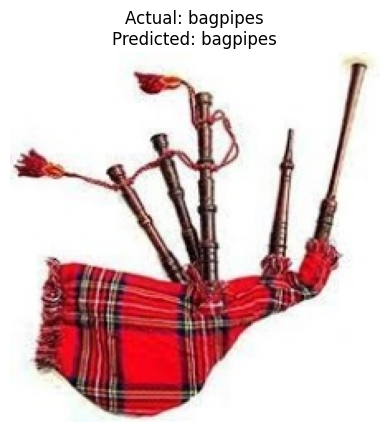

In [33]:
# Test the function with the loaded model that predicts the class of a random image
test_random_image(loaded_model, test_gen, img_size=IMG_SIZE)